# [The Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting)

The idea is to predict crypto prices with the given datasets. See link above for full details of the competition. For this particular problem, I am going to use ARIMA time-series forecasting to predict crypto prices.

# Import Dependencies

In [1]:
import pickle
import datetime

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots

import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model
import statsmodels.api as sm

import pickle
%matplotlib inline

from sklearn.metrics import mean_absolute_error # Importing metrics

# Define Custom Functions

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n=15):
    """
    Calculate average of last n observations
    """
    return np.average(series[-n:])

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    """
    df - dataframe with timeseries
    column_name - name of column to analyze (choose 1 at a time)
    window - rolling window size 
    plot_intervals - show confidence intervals
    plot_anomalies - show anomalies 

    """

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "red", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(
            series[window:], rolling_mean[window:]
        )
        
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
            
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(b=True)

def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    values = series.values
    result = [values[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * values[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas, plot_intervals = False, scale = 1.96, plot_anomalies=False):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """  
    plt.figure(figsize=(15, 5))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), color="orange", label="Alpha {}".format(alpha))
    plt.plot(series.values, "b", label = "Actual")
    plt.title("Exponential Smoothing")
    plt.legend(loc="best")
    plt.axis('tight')
    
    if plot_intervals:
        mae = mean_absolute_error(
            series, exponential_smoothing(series, alpha)
        )
        
        deviation = np.std(series - exponential_smoothing(series, alpha))
        lower_bound = exponential_smoothing(series, alpha) - (mae + scale * deviation)
        upper_bound = exponential_smoothing(series, alpha) + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" lower-bound anomalies found"))
            anomalies[series>upper_bound] = series[series>upper_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" upper-bound anomalies found"))
            plt.plot(anomalies, "black", markersize=10)
        
    plt.legend(loc="best")
    plt.grid(b=True)
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey-Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    
    with plt.style.context(style):   
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

# Load the data

In [3]:
data_folder = "/Users/dominguez/Documents/Kaggle_G_Research_Crypto/data/"
train = pd.read_csv(data_folder + "train.csv")
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

# Clean datasets

In [4]:
# Let's take at a look at single asset for now (BTC)
btc_asset_id = 1
btc = train[train["Asset_ID"] == btc_asset_id].set_index("timestamp")

In [5]:
btc.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

For time-series data, missing data is not necessarily represented by NaNs, but by the absence of rows (gaps in the data)

In [6]:
(btc.index[1:]-btc.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

There are roughly 78 gaps 120 seconds wide, and so on. It is important to reformat the data to remove these gaps so we only have 60-second gaps

In [7]:
# Remove the NaNs
# This will leave gaps in the time-series. But we'll deal with this soon
btc.dropna(axis=0, inplace=True)

In [8]:
# Use .reindex() to fill the gaps
btc = btc.reindex(range(btc.index[0], btc.index[-1] + 60, 60), method='pad')
(btc.index[1:] - btc.index[:-1]).value_counts().head()

60    1956943
Name: timestamp, dtype: int64

In [9]:
# Confirm
btc.isna().sum().sum()

0

# EDA

In [10]:
beg_btc = datetime.datetime.fromtimestamp(btc.index[0]).strftime('%Y-%m-%d %H:%M:%S')
end_btc = datetime.datetime.fromtimestamp(btc.index[-1]).strftime('%Y-%m-%d %H:%M:%S')

print('BTC minute data goes from ', beg_btc, 'to ', end_btc)

BTC minute data goes from  2017-12-31 16:01:00 to  2021-09-20 16:44:00


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [12]:
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin_Cash
1,0,4.304065,Binance_Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS
4,7,2.079442,Ethereum_Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [13]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [14]:
btc.tail()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1632181200,1,2643.0,42632.46500,42736.90,42607.50,42703.636250,100.797218,42653.031385,0.002084
1632181260,1,2281.0,42718.81500,42819.38,42690.84,42781.970571,76.339988,42755.785162,0.003246
1632181320,1,2642.0,42772.92125,42827.10,42690.75,42755.592500,117.429123,42749.075916,0.003108
1632181380,1,2134.0,42762.29000,42811.30,42694.37,42717.234286,78.049458,42749.024591,0.002770
1632181440,1,2165.0,42703.80250,42752.00,42636.76,42657.202500,86.518794,42680.263993,0.002726


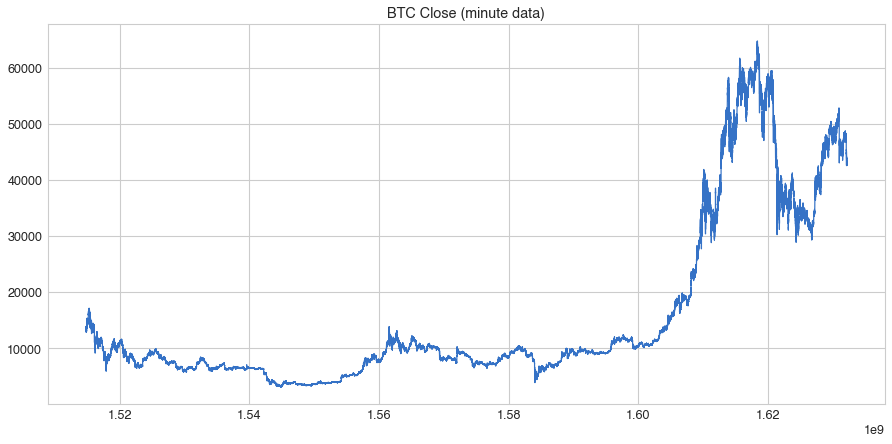

In [15]:
# Let's plot the close
plt.figure(figsize=(15, 7))
plt.plot(btc.Close)
plt.title('BTC Close (minute data)')
plt.grid(True)
plt.show()

In [16]:
# Before moving forward, let's create a shorter version of our dataset for plotting
btc_mini = btc.copy()
btc_mini = btc_mini.iloc[-500:, :]

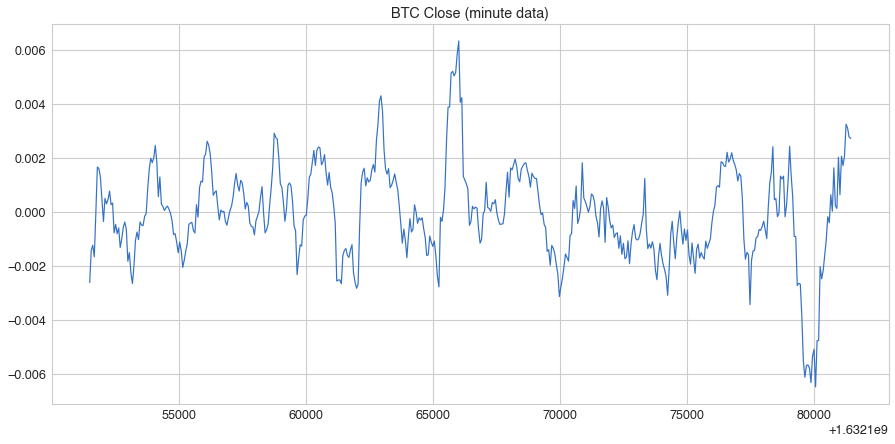

In [17]:
# Plot teturns
plt.figure(figsize=(15, 7))
plt.plot(btc_mini.Target)
plt.title('BTC Close (minute data)')
plt.grid(True)
plt.show()

Moving average

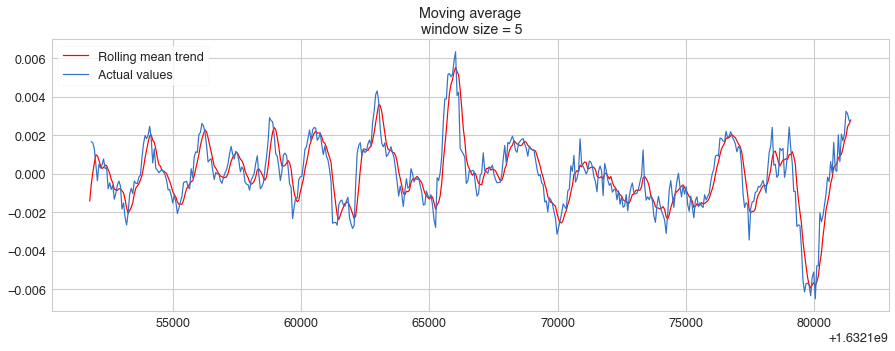

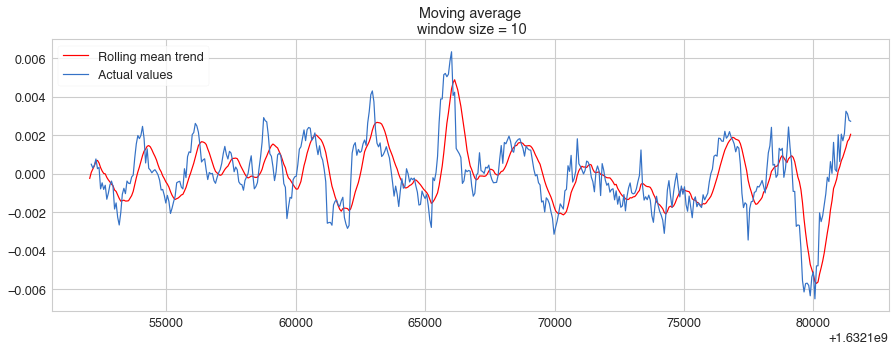

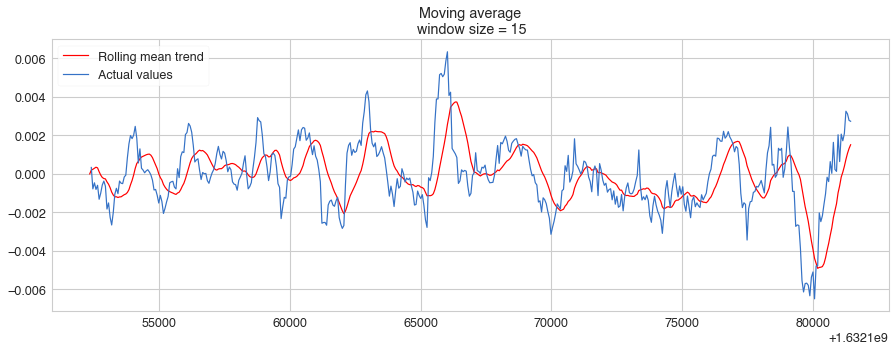

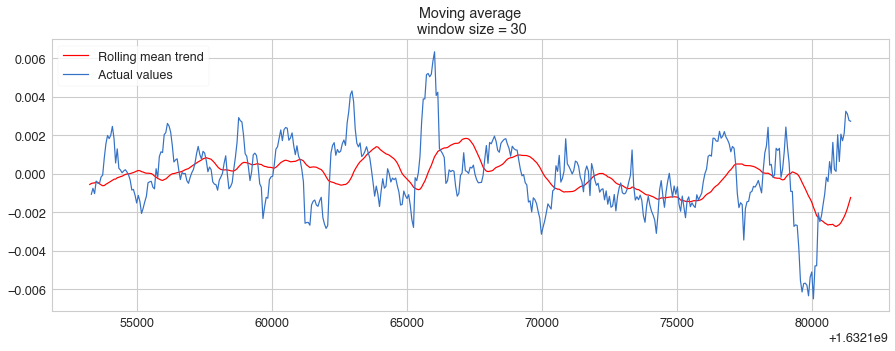

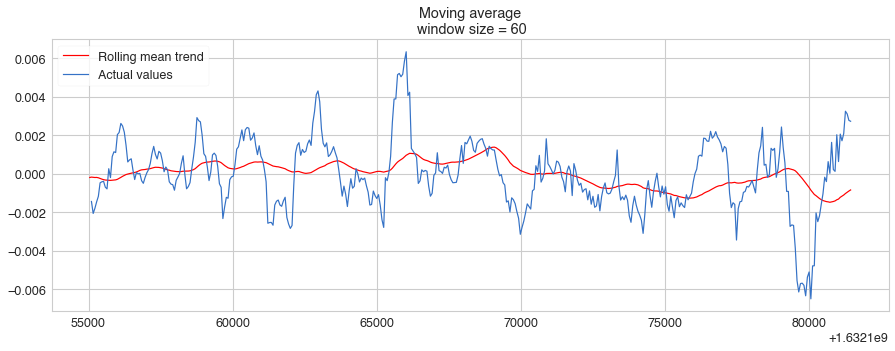

In [18]:
# Let's take a look at several moving averages
windows = [5, 10, 15, 30, 60]
for window in windows:
    plotMovingAverage(btc_mini.Target, window=window)

<ipython-input-2-e8e9164b5492>:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  anomalies = pd.Series(index=series.index, name=series.name)
<ipython-input-2-e8e9164b5492>:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  anomalies = pd.Series(index=series.index, name=series.name)
<ipython-input-2-e8e9164b5492>:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  anomalies = pd.Series(index=series.index, name=series.name)
<ipython-input-2-e8e9164b5492>:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  anomalie

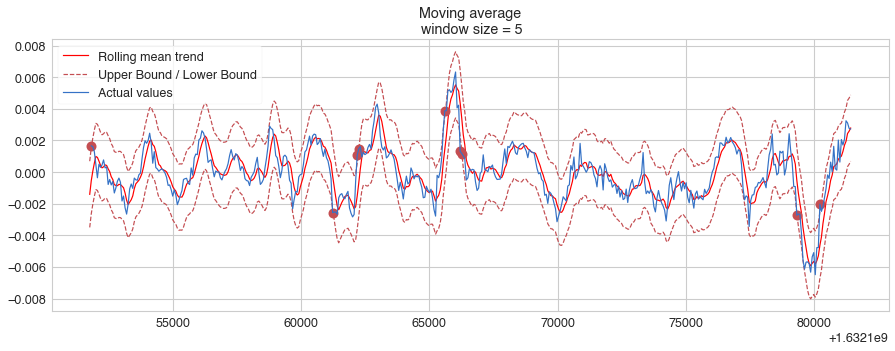

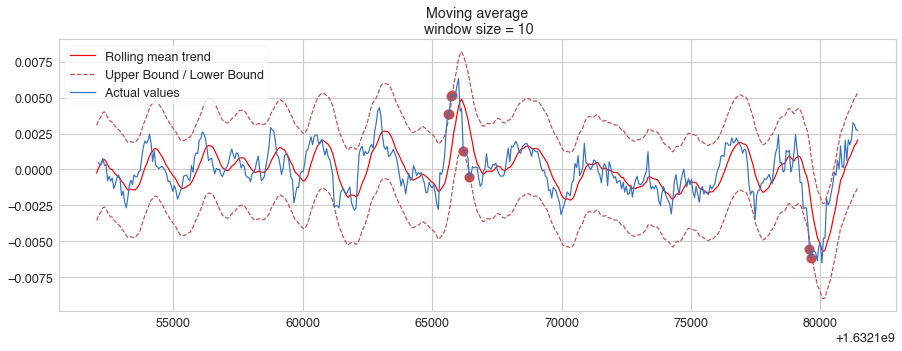

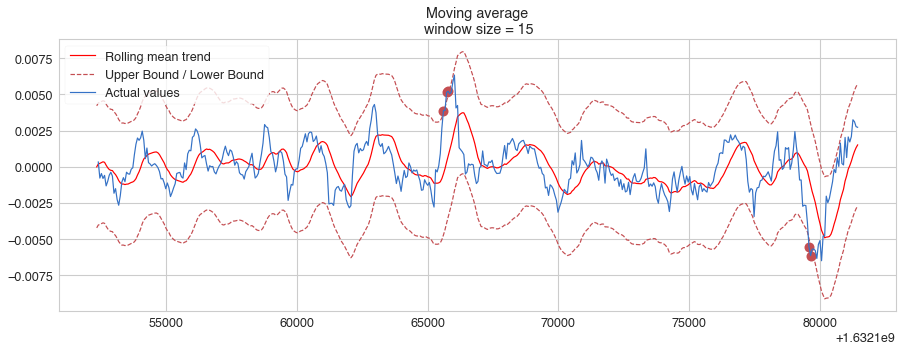

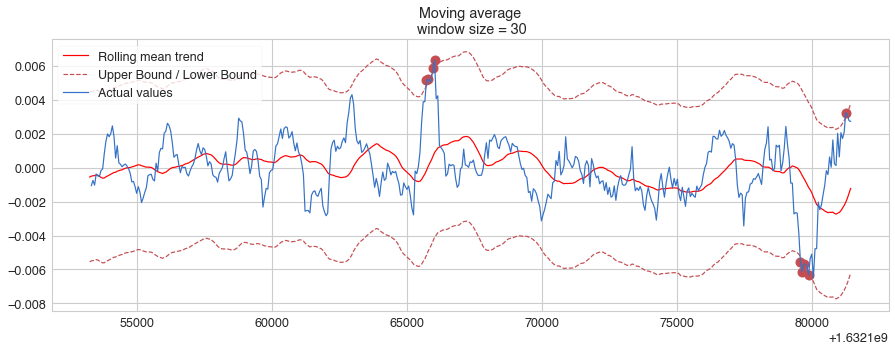

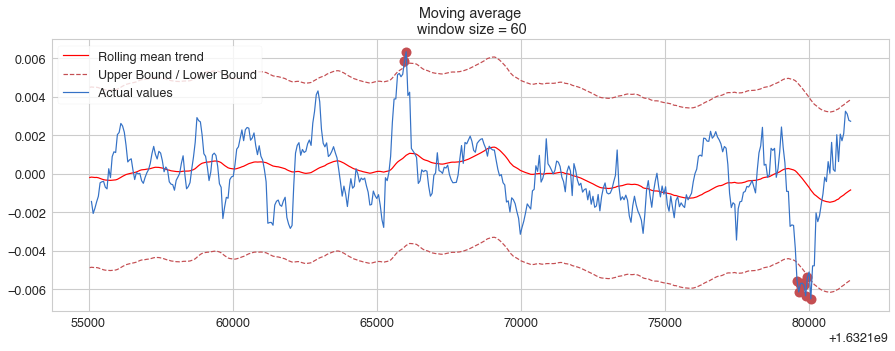

In [19]:
# Now, let's create a simple anomaly detection system with the help of the moving average
import warnings
warnings.filterwarnings('ignore')
windows = [5, 10, 15, 30, 60]
for window in windows:
    plotMovingAverage(btc_mini.Target, window=window, plot_intervals=True, plot_anomalies=True)

Looks like it does a decent job of detecting anomalies

Exponential Smoothing

The goal with exponential smoothing is to smooth out more recent data points by weighting (applying $\alpha$ to) more recent data points. This helps us "smooth" the data for better predictability.

Mathematically:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

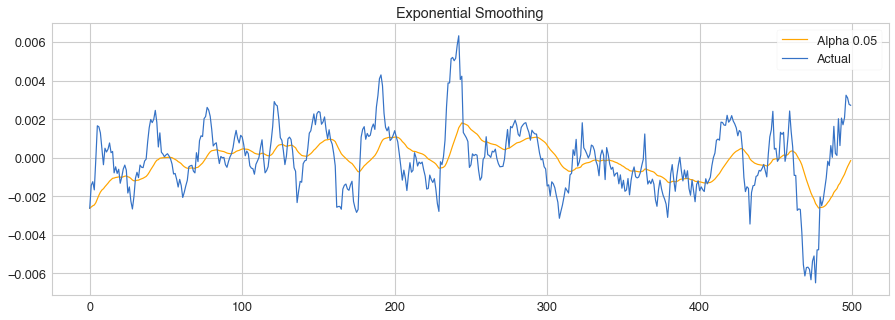

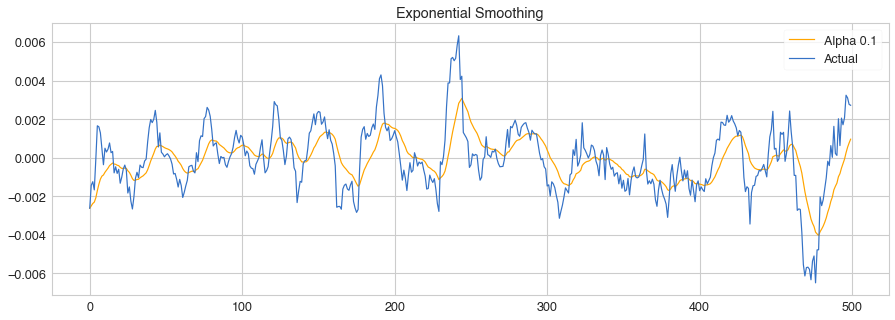

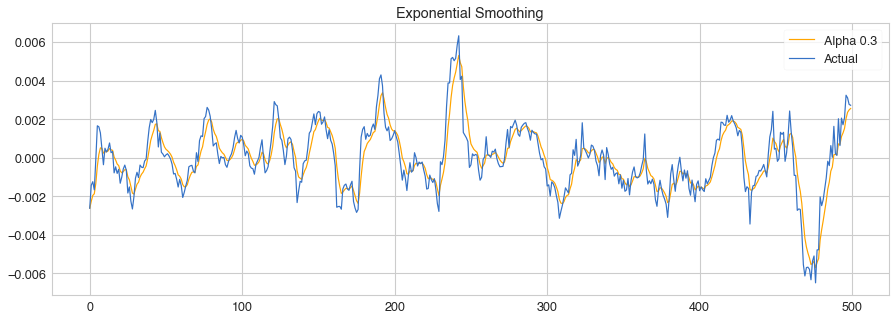

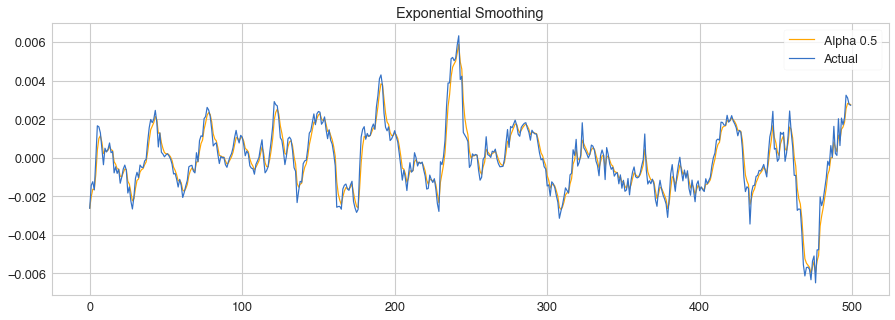

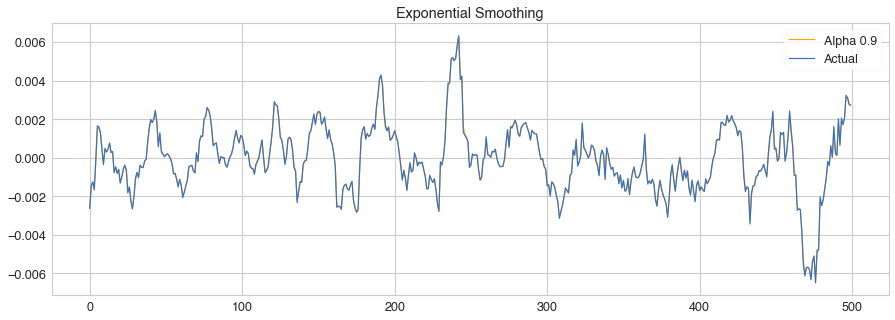

In [20]:
alphas = [.05, .1, .3, .5, .9]
for alpha in alphas:
    plotExponentialSmoothing(btc_mini.Target, alphas=[alpha])

When comparing smaller alphas to larger alphas, it is clear larger alphas tend to transform the data in a way that flattens the series, potentially allowing for better predictability. To be certain, let's perform a Dickey-Fuller Test

Stationarity

Stationarity is crucial for time-series forecasting. It implies the statistical properties of the data have NO correlation with time. A stationary process is much more predictable than a non-stationary process (such as equities, crypto, etc.)

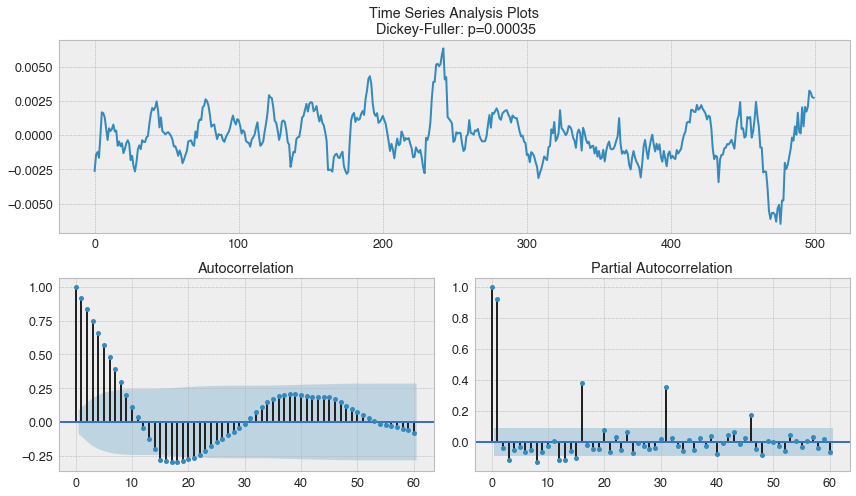

In [28]:
tsplot(btc_mini.Target.values, lags=60)

Lets smooth it out with exponential smoothing and retry Dickey-Fuller Test

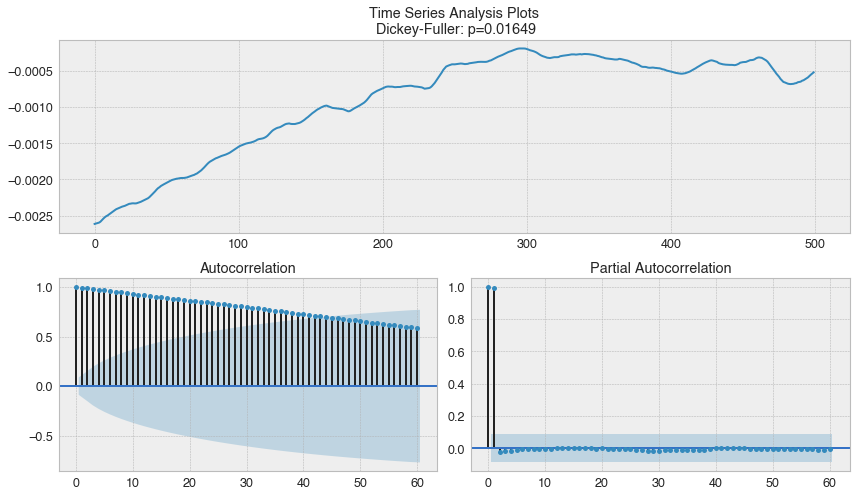

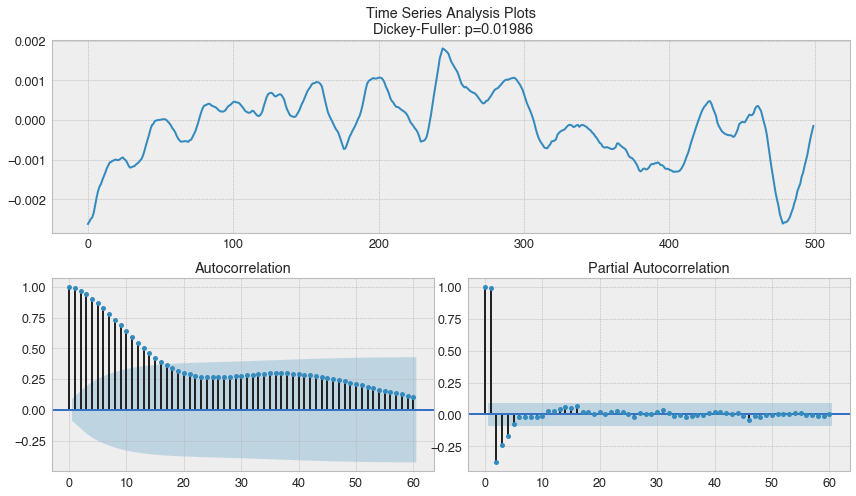

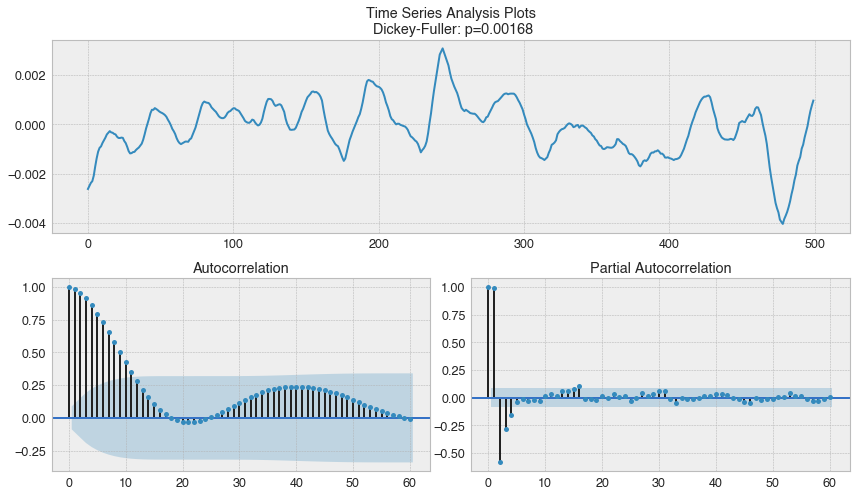

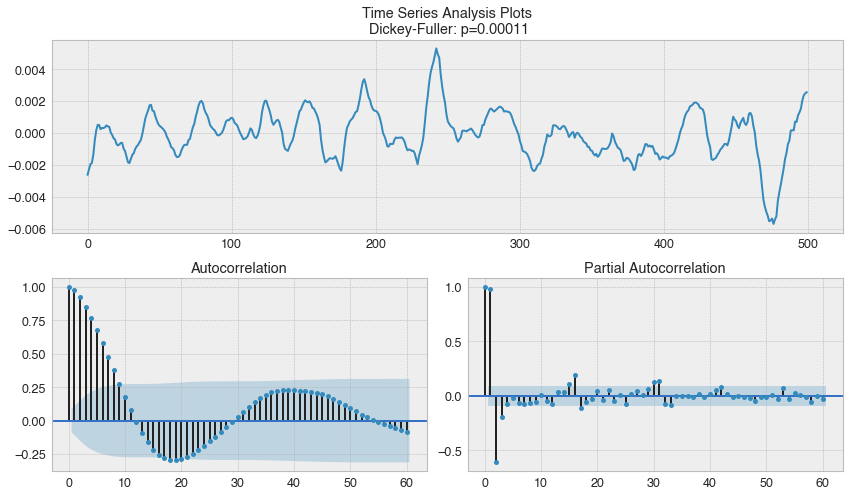

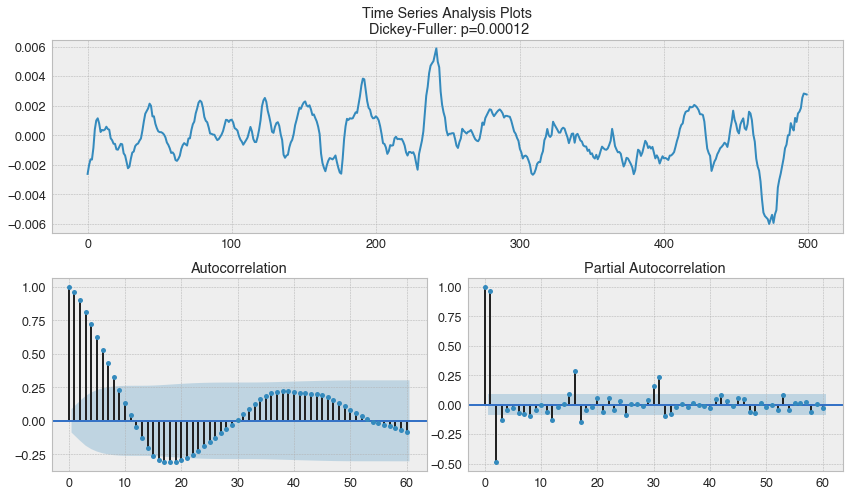

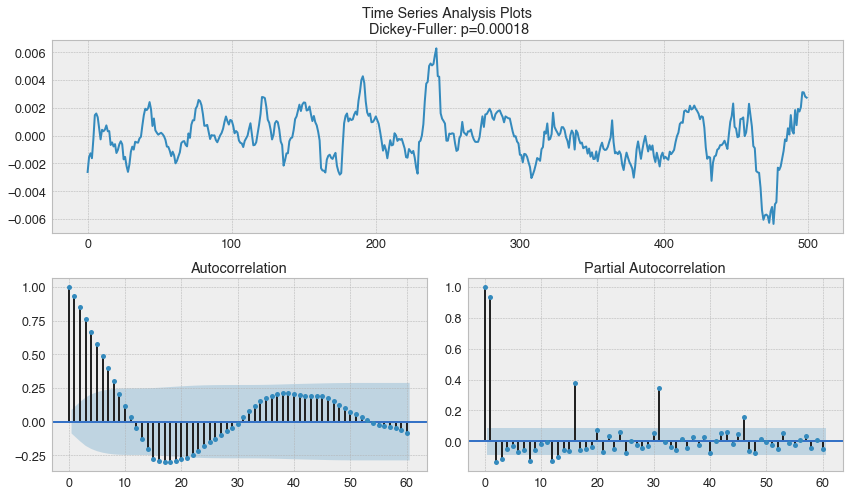

In [22]:
alphas = [.005, .05, .1, .3, .5, .9]
for alpha in alphas:
    current_series = exponential_smoothing(btc_mini.Target, alpha)
    tsplot(current_series, lags=60)

Let's try taking a first-order difference and see if this helps our cause

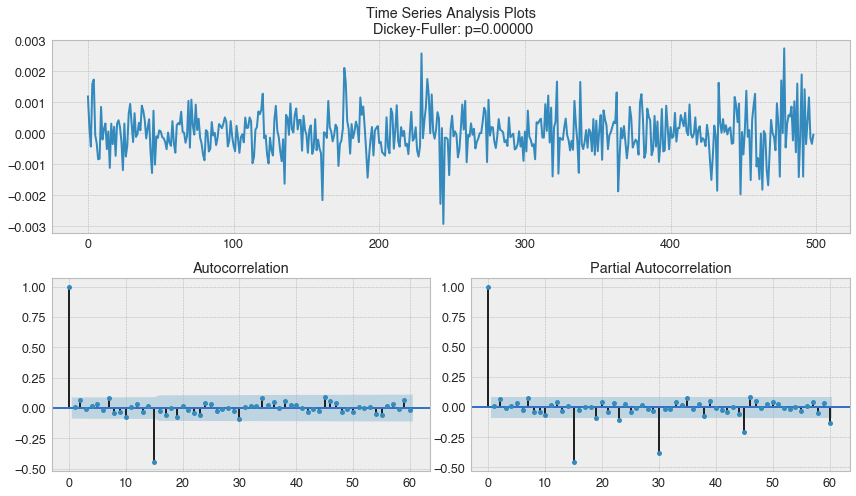

In [23]:
btc_mini_diff = btc_mini.Target - btc_mini.Target.shift(1)
tsplot(btc_mini_diff[1:].values, lags=60)

The ARIMA(p, d, q) Model

Let's go with exponential smoothing with an alpha=0.005. The logic behind is to input a smooth and stationary process into the model. We noticed from above that the p-value with this alpha is less than 0.05, which implies stationarity. 

Now we have a dataset that looks stationary and passes a Dickey-Fuller Test with a p-value of approximately 0. Based on the ACF, the 15th lag seems to be significant. And for the PACF, the 15th and 30th lag seem to have some significance. Therefore, we will try the following parameters:
- p = 2
- d = 0
- q = 13

# Model

Bitcoin_Cash, 2 AIC: -10743.522154153916
Binance_Coin, 0 AIC: -9960.807512548357
Bitcoin, 1 AIC: -11148.850254639716
EOS, 5 AIC: -10591.962829530814
Ethereum_Classic, 7 AIC: -10644.17690269151
Ethereum, 6 AIC: -10966.420176374218
Litecoin, 9 AIC: -10689.921225128068
Monero, 11 AIC: -9828.72599542237
TRON, 13 AIC: -10078.671708775346
Stellar, 12 AIC: -10562.036498755735
Cardano, 3 AIC: -10542.921486579085
IOTA, 8 AIC: -9039.892270239267
Maker, 10 AIC: -9766.56047083699
Dogecoin, 4 AIC: -10573.704907689324
CPU times: user 32.6 s, sys: 4.05 s, total: 36.7 s
Wall time: 27.4 s


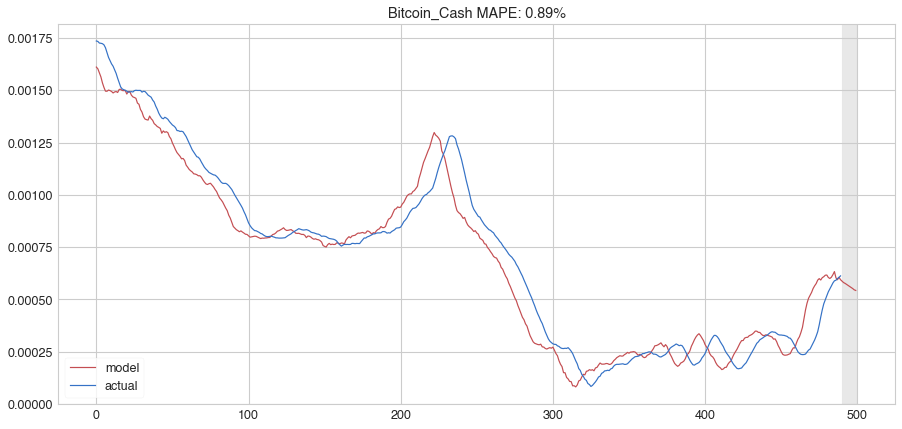

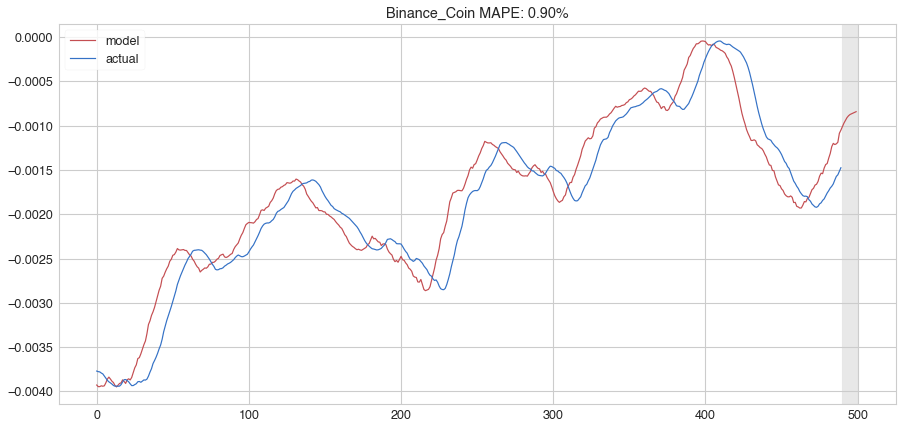

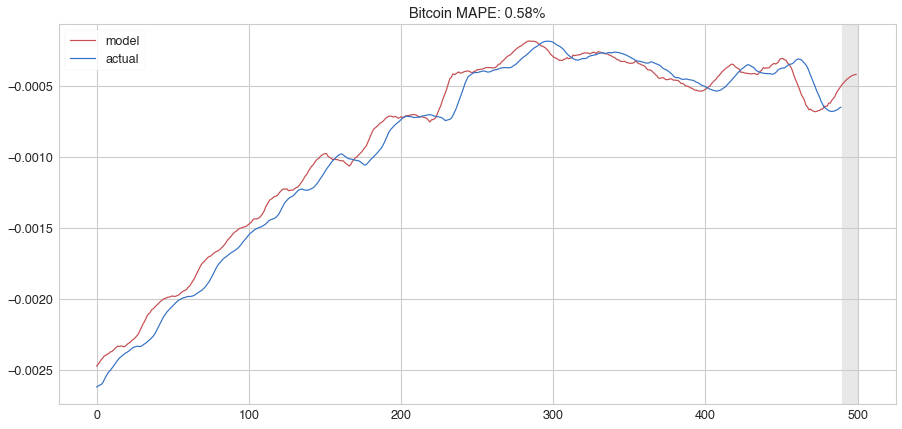

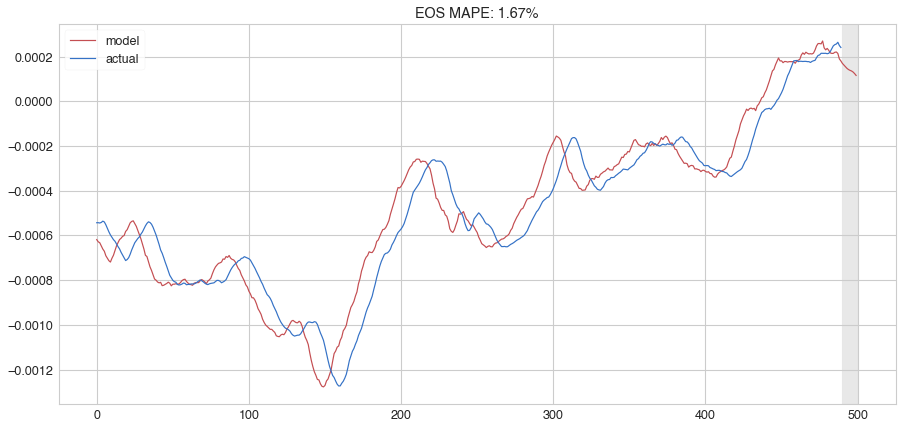

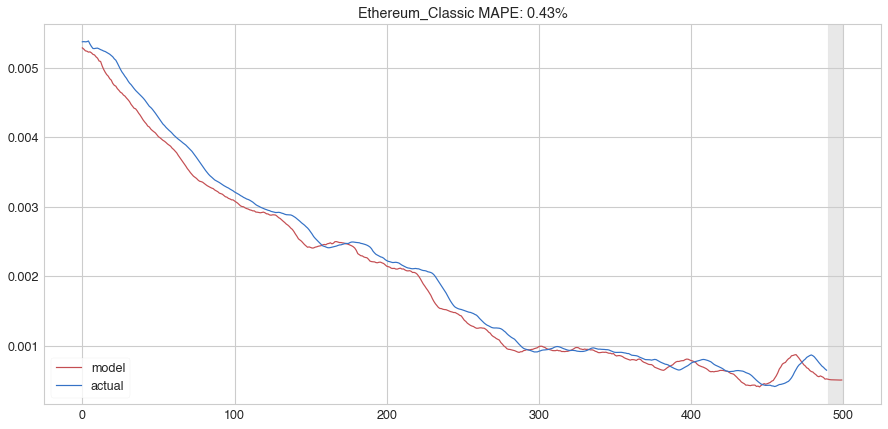

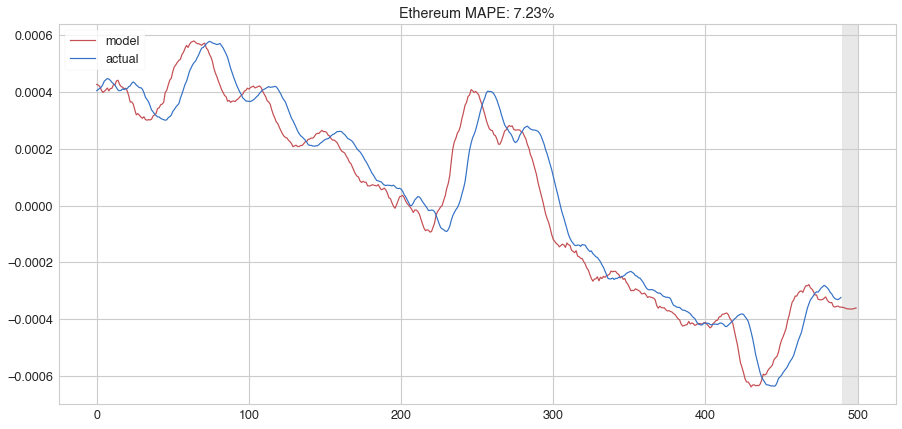

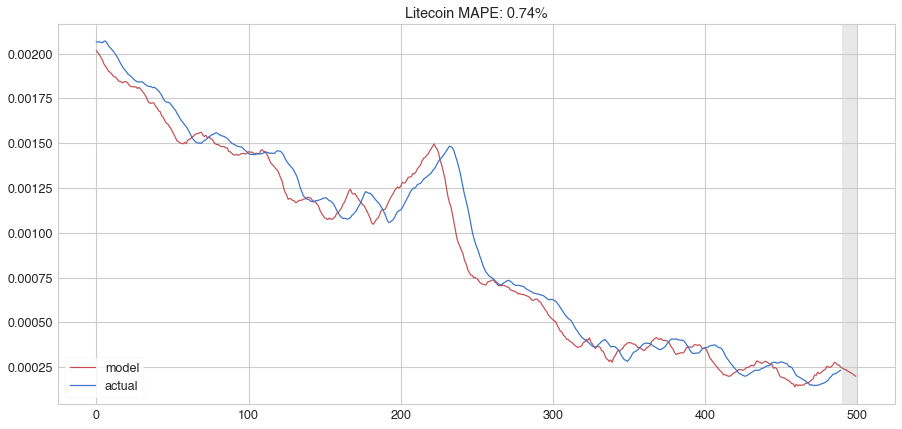

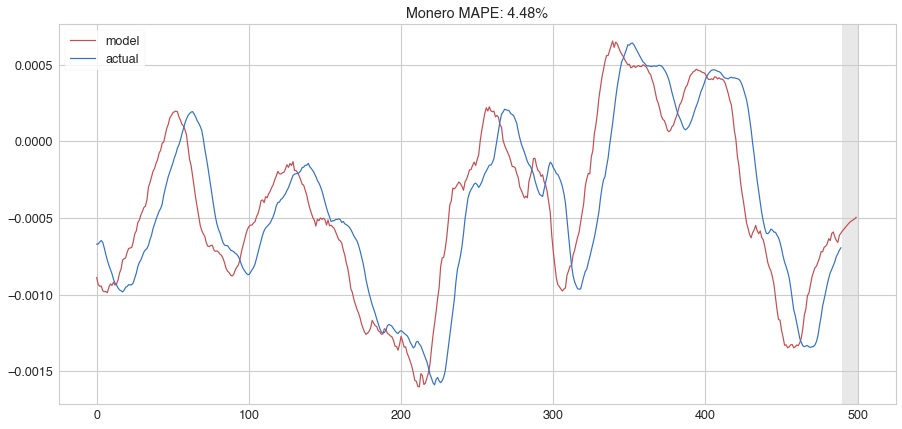

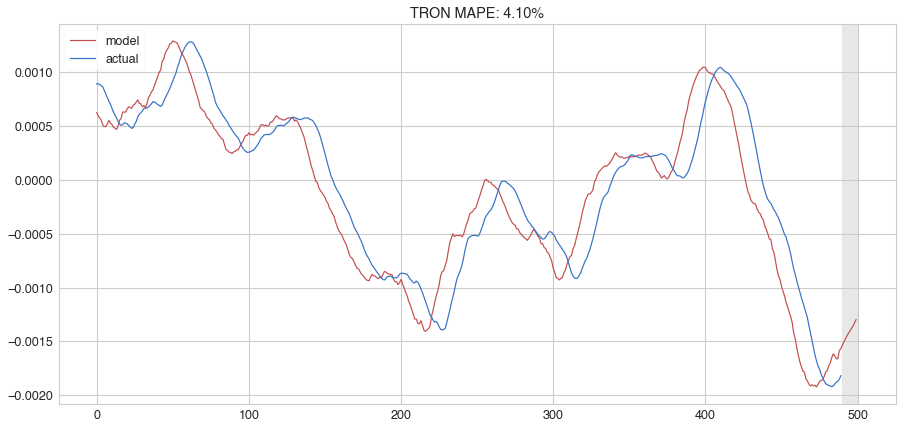

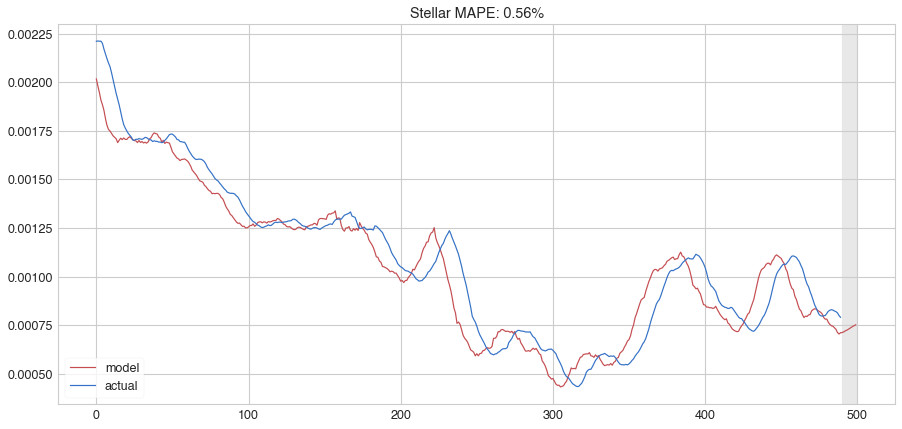

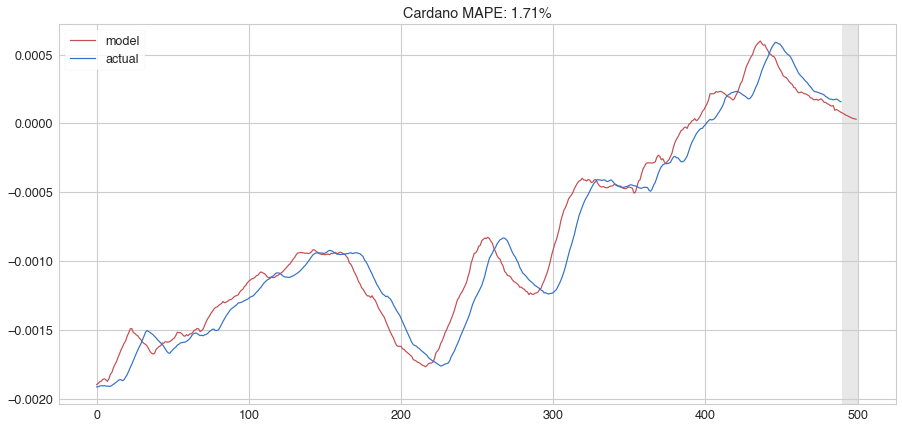

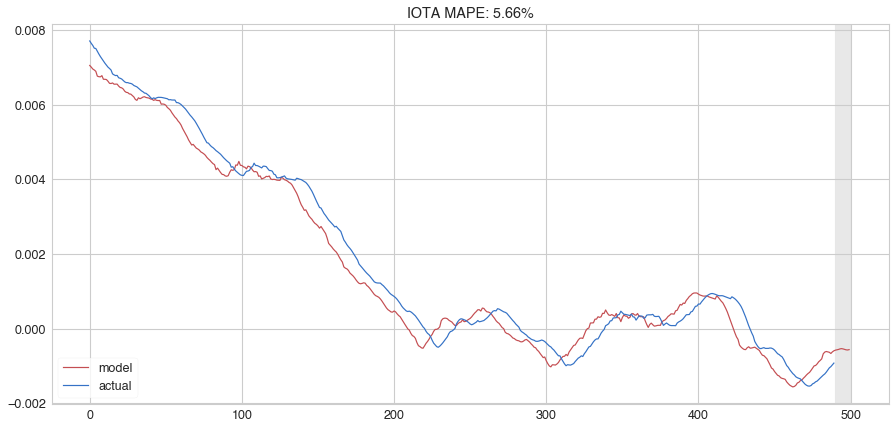

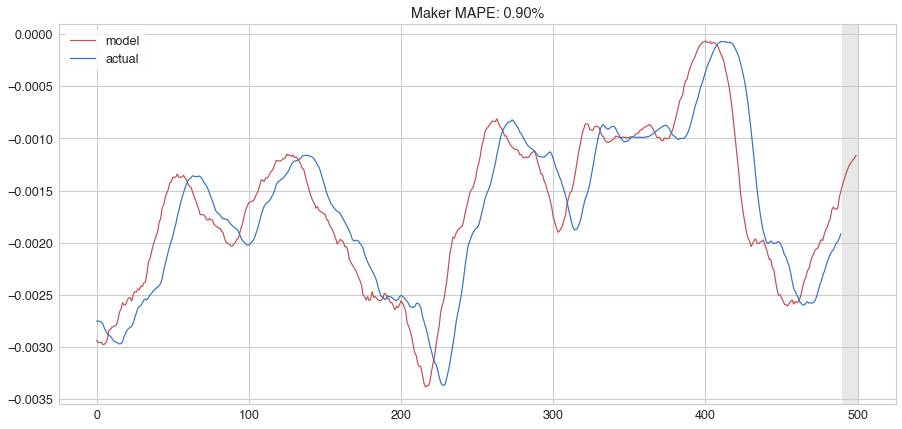

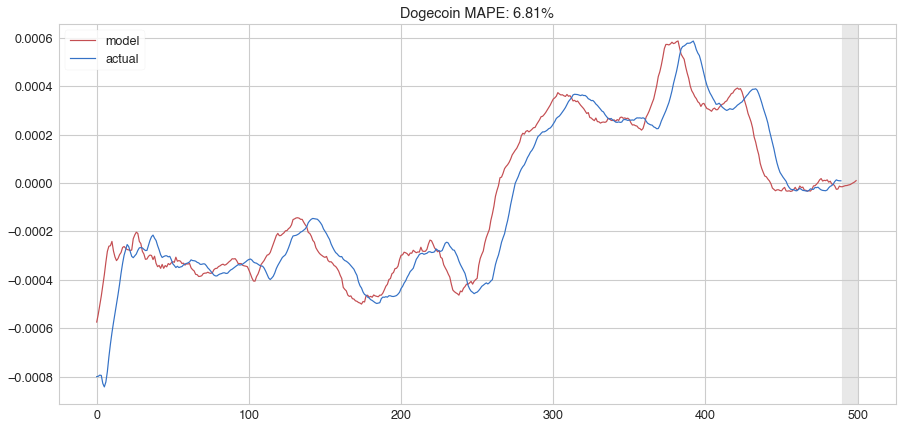

In [30]:
%%time
import warnings
warnings.filterwarnings('ignore')
n_steps_to_train = 500
n_steps_to_plot = 500
n_steps_to_predict = 10
p = 2
d = 0
q = 13
alpha = 0.005
models = dict()
errors = dict()
forecasts = dict()

for i in range(len(asset_details)):
    current_id = asset_details.Asset_ID[i]
    current_asset_name = asset_details.Asset_Name[i]
    suffix = "_train.pickle"
    
    # Load individual dataset
    with open(data_folder + current_asset_name + suffix, "rb") as f:
        current_dataset = pickle.load(f)
    
    # Calculate exponential smoothing
    current_dataset_mini = current_dataset.copy()[-n_steps_to_train:]
    current_dataset_mini["Smoothed"] = exponential_smoothing(current_dataset_mini.Target, alpha=alpha)
    data = current_dataset_mini["Smoothed"]
    
    # Train our model
    model = statsmodels.tsa.arima.model.ARIMA(endog=data.values, exog=None, order=(p,d,q)).fit() 
    aic = model.aic
    print(f"{current_asset_name}, {current_id} AIC: {aic}")
    
    # Forecasting
    actual = np.array(data.values)
    arima_model = np.array(model.fittedvalues)
    forecast = list(model.predict(start = len(actual), end = len(actual)+n_steps_to_predict))
    forecast = list(arima_model) + forecast
    
    # Save feedback
    forecasts[current_id] = forecast
    models[current_id] = model
    errors[current_id] = mean_absolute_percentage_error(actual, arima_model)
    
    # Save model
    with open(f"./models/{current_id}.pickle", "wb") as f:
        pickle.dump(model, f, protocol=4)
    
    # Plot results 
    plt.figure(figsize=(15, 7))
    plt.title(f"{current_asset_name} MAPE: {errors[current_id]:.2f}%")
    plt.plot(forecast[-n_steps_to_plot:], color='r', label="model")
    plt.axvspan(len(forecast[-n_steps_to_plot:])-n_steps_to_predict, len(forecast[-n_steps_to_plot:]), alpha=0.5, color='lightgrey')
    plt.plot(actual[-n_steps_to_plot:-n_steps_to_predict], label="actual")
    plt.legend()
    plt.grid(True);

# Conclusions

These are decent results. The exponential smoothing process applies decaying weights over the series, ensuring lags that are far behind hold minimal importance. To optimize scores, I would like to eventually conduct hyperparameter optimization